In [ ]:
import os, json
import numpy as np
import models
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from engine import train, validate, test
from dataset import ClevrPOCDataSet
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel

import pickle


In [2]:
DATA_FOLDER_NAME = 'output-12000'
DATA_FOLDER = '/home/marjan/code/CLEVR-POC/clevr-poc-dataset-gen/' + DATA_FOLDER_NAME + '/incomplete'
ENVIRONMENT_FOLDER = '/home/marjan/code/CLEVR-POC/clevr-poc-dataset-gen/environment_constraints'

In [3]:

with open(os.path.join('/home/marjan/code/CLEVR-POC/clevr-poc-dataset-gen', 'data', 'properties.json'), encoding="utf-8") as f:
    properties = json.load(f)


key_properties_values = []
for key_property in properties:
    if key_property == 'regions':
        continue
    key_properties_values.extend(properties[key_property].keys())

total_labels_to_index = {k: v for v, k in enumerate(key_properties_values)}
total_labels_to_index


{'cube': 0,
 'sphere': 1,
 'cylinder': 2,
 'cone': 3,
 'gray': 4,
 'red': 5,
 'blue': 6,
 'green': 7,
 'brown': 8,
 'purple': 9,
 'cyan': 10,
 'yellow': 11,
 'rubber': 12,
 'metal': 13,
 'large': 14,
 'medium': 15,
 'small': 16}

In [4]:

matplotlib.style.use('ggplot')
# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_preprocess = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
#clip_model_path = "openai/clip-vit-base-patch32"
#clip_model, clip_preprocess = clip.load('ViT-B/32', device)


In [5]:
#intialize the model

clip_embedding_dim = 512
env_embedding_dim = 768
clip_model, final_classifier = models.model(requires_grad=False, 
                                      clip_model = clip_model,
                                      #checkpoint=clip_model_path,
                                      clip_embedding_dim=clip_embedding_dim,
                                      env_embedding_dim = env_embedding_dim,
                                      output_dim=len(total_labels_to_index))

clip_model.to(device)
final_classifier.to(device)

dropout = nn.Dropout(0.1) # ????

# learning parameters
lr = 0.001
epochs = 200
batch_size = 8
optimizer = optim.Adam(final_classifier.parameters(), lr=lr)
criterion = nn.BCELoss()
dropout = nn.Dropout(0.1)

validation_threshold = 0.5



In [6]:
# train dataset
train_data = ClevrPOCDataSet(DATA_FOLDER, 'training', total_labels_to_index, ENVIRONMENT_FOLDER)

# validation dataset
valid_data = ClevrPOCDataSet(DATA_FOLDER, 'validation', total_labels_to_index, ENVIRONMENT_FOLDER)

# train data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# validation data loader
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

print('a')

a


In [7]:
# start the training and validation
train_loss = []
valid_loss = []
valid_acc = []
best_validation_acc = 0
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(final_classifier, clip_model, train_loader, optimizer, criterion, train_data, device, dropout, clip_preprocess)
    valid_epoch_loss, valid_epoch_acc = validate(final_classifier, clip_model, valid_loader, criterion, valid_data, device, dropout, clip_preprocess, validation_threshold)
    if best_validation_acc > valid_epoch_acc:
        best_validation_acc = valid_epoch_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': final_classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'outputs/best_model_' + DATA_FOLDER_NAME + '.pth')

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    valid_acc.append(valid_epoch_acc)
    
    with open('outputs/train_loss_' + DATA_FOLDER_NAME + '.pickle', 'wb') as f:
        pickle.dump(train_loss, f)
    with open('outputs/val_loss_' + DATA_FOLDER_NAME + '.pickle', 'wb') as f:
        pickle.dump(valid_loss, f)
    with open('outputs/val_acc' + DATA_FOLDER_NAME + '.pickle', 'wb') as f:
        pickle.dump(valid_acc, f)        
     
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')
    print(f'Val Acc: {valid_epoch_acc:.4f}')

Epoch 1 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [12:30<00:00,  2.00it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:09<00:00,  2.17it/s]


Train Loss: 0.3987
Val Loss: 0.3618
Val Acc: 0.8447
Epoch 2 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.54it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.85it/s]


Train Loss: 0.3410
Val Loss: 0.3301
Val Acc: 0.8624
Epoch 3 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.67it/s]


Train Loss: 0.3160
Val Loss: 0.3173
Val Acc: 0.8592
Epoch 4 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:00<00:00, 12.49it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.3007
Val Loss: 0.3025
Val Acc: 0.8576
Epoch 5 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.2904
Val Loss: 0.2939
Val Acc: 0.8655
Epoch 6 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.2812
Val Loss: 0.2849
Val Acc: 0.8745
Epoch 7 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.2748
Val Loss: 0.2776
Val Acc: 0.8737
Epoch 8 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.2679
Val Loss: 0.2775
Val Acc: 0.8784
Epoch 9 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.2635
Val Loss: 0.2728
Val Acc: 0.8773
Epoch 10 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.2589
Val Loss: 0.2663
Val Acc: 0.8808
Epoch 11 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.2554
Val Loss: 0.2656
Val Acc: 0.8847
Epoch 12 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.83it/s]


Train Loss: 0.2514
Val Loss: 0.2612
Val Acc: 0.8867
Epoch 13 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.2491
Val Loss: 0.2658
Val Acc: 0.8776
Epoch 14 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.2448
Val Loss: 0.2560
Val Acc: 0.8843
Epoch 15 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.2429
Val Loss: 0.2566
Val Acc: 0.8753
Epoch 16 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.65it/s]


Train Loss: 0.2404
Val Loss: 0.2552
Val Acc: 0.8831
Epoch 17 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.2374
Val Loss: 0.2490
Val Acc: 0.8831
Epoch 18 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.2358
Val Loss: 0.2517
Val Acc: 0.8902
Epoch 19 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.80it/s]


Train Loss: 0.2347
Val Loss: 0.2493
Val Acc: 0.8847
Epoch 20 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.2332
Val Loss: 0.2434
Val Acc: 0.8918
Epoch 21 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.2310
Val Loss: 0.2426
Val Acc: 0.8918
Epoch 22 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.83it/s]


Train Loss: 0.2294
Val Loss: 0.2448
Val Acc: 0.8886
Epoch 23 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.53it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.2290
Val Loss: 0.2424
Val Acc: 0.8898
Epoch 24 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.56it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 12.34it/s]


Train Loss: 0.2267
Val Loss: 0.2436
Val Acc: 0.8922
Epoch 25 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.53it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.68it/s]


Train Loss: 0.2252
Val Loss: 0.2541
Val Acc: 0.8898
Epoch 26 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.57it/s]


Train Loss: 0.2235
Val Loss: 0.2399
Val Acc: 0.8945
Epoch 27 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.58it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.63it/s]


Train Loss: 0.2222
Val Loss: 0.2341
Val Acc: 0.8933
Epoch 28 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.67it/s]


Train Loss: 0.2213
Val Loss: 0.2354
Val Acc: 0.8996
Epoch 29 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.52it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.57it/s]


Train Loss: 0.2208
Val Loss: 0.2348
Val Acc: 0.8902
Epoch 30 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.2197
Val Loss: 0.2376
Val Acc: 0.8918
Epoch 31 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.50it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.2184
Val Loss: 0.2361
Val Acc: 0.8949
Epoch 32 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.85it/s]


Train Loss: 0.2178
Val Loss: 0.2379
Val Acc: 0.8898
Epoch 33 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.2169
Val Loss: 0.2326
Val Acc: 0.8933
Epoch 34 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.2162
Val Loss: 0.2338
Val Acc: 0.8988
Epoch 35 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.84it/s]


Train Loss: 0.2155
Val Loss: 0.2355
Val Acc: 0.8914
Epoch 36 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.80it/s]


Train Loss: 0.2144
Val Loss: 0.2326
Val Acc: 0.8945
Epoch 37 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.2135
Val Loss: 0.2296
Val Acc: 0.8976
Epoch 38 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.56it/s]


Train Loss: 0.2127
Val Loss: 0.2315
Val Acc: 0.8957
Epoch 39 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.80it/s]


Train Loss: 0.2117
Val Loss: 0.2297
Val Acc: 0.8973
Epoch 40 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.2109
Val Loss: 0.2307
Val Acc: 0.8953
Epoch 41 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.52it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.2113
Val Loss: 0.2384
Val Acc: 0.8945
Epoch 42 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.52it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.2102
Val Loss: 0.2301
Val Acc: 0.8902
Epoch 43 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.55it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.61it/s]


Train Loss: 0.2098
Val Loss: 0.2286
Val Acc: 0.8965
Epoch 44 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:01<00:00, 12.34it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.81it/s]


Train Loss: 0.2085
Val Loss: 0.2269
Val Acc: 0.8984
Epoch 45 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.2092
Val Loss: 0.2273
Val Acc: 0.8925
Epoch 46 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.2068
Val Loss: 0.2273
Val Acc: 0.8980
Epoch 47 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.2073
Val Loss: 0.2244
Val Acc: 0.9027
Epoch 48 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.2066
Val Loss: 0.2307
Val Acc: 0.9000
Epoch 49 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.51it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.63it/s]


Train Loss: 0.2054
Val Loss: 0.2300
Val Acc: 0.8965
Epoch 50 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.52it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.2054
Val Loss: 0.2229
Val Acc: 0.9035
Epoch 51 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:00<00:00, 12.46it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.56it/s]


Train Loss: 0.2060
Val Loss: 0.2252
Val Acc: 0.9024
Epoch 52 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:03<00:00, 12.16it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.2048
Val Loss: 0.2272
Val Acc: 0.8976
Epoch 53 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.56it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 12.30it/s]


Train Loss: 0.2040
Val Loss: 0.2262
Val Acc: 0.8984
Epoch 54 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:05<00:00, 11.91it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 12.33it/s]


Train Loss: 0.2040
Val Loss: 0.2222
Val Acc: 0.9031
Epoch 55 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:05<00:00, 11.99it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 11.97it/s]


Train Loss: 0.2038
Val Loss: 0.2228
Val Acc: 0.8976
Epoch 56 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:05<00:00, 11.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 12.11it/s]


Train Loss: 0.2022
Val Loss: 0.2341
Val Acc: 0.9027
Epoch 57 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [07:53<00:00,  3.17it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:19<00:00,  1.89it/s]


Train Loss: 0.2032
Val Loss: 0.2238
Val Acc: 0.9000
Epoch 58 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [05:42<00:00,  4.38it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:14<00:00, 10.33it/s]


Train Loss: 0.2015
Val Loss: 0.2197
Val Acc: 0.9000
Epoch 59 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:29<00:00, 10.05it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:16<00:00,  9.31it/s]


Train Loss: 0.2014
Val Loss: 0.2179
Val Acc: 0.9008
Epoch 60 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:02<00:00, 12.22it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.2004
Val Loss: 0.2189
Val Acc: 0.9075
Epoch 61 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:01<00:00, 12.33it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 12.06it/s]


Train Loss: 0.2004
Val Loss: 0.2224
Val Acc: 0.8933
Epoch 62 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:02<00:00, 12.24it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 12.48it/s]


Train Loss: 0.2005
Val Loss: 0.2223
Val Acc: 0.8953
Epoch 63 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.2001
Val Loss: 0.2272
Val Acc: 0.8957
Epoch 64 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:00<00:00, 12.42it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 12.42it/s]


Train Loss: 0.2004
Val Loss: 0.2195
Val Acc: 0.9024
Epoch 65 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:01<00:00, 12.36it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 12.21it/s]


Train Loss: 0.1995
Val Loss: 0.2185
Val Acc: 0.8949
Epoch 66 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:00<00:00, 12.41it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.1993
Val Loss: 0.2252
Val Acc: 0.9000
Epoch 67 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.63it/s]


Train Loss: 0.2000
Val Loss: 0.2214
Val Acc: 0.8980
Epoch 68 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:00<00:00, 12.49it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 11.89it/s]


Train Loss: 0.1987
Val Loss: 0.2220
Val Acc: 0.9000
Epoch 69 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:01<00:00, 12.30it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.56it/s]


Train Loss: 0.1972
Val Loss: 0.2275
Val Acc: 0.8969
Epoch 70 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:01<00:00, 12.38it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 12.37it/s]


Train Loss: 0.1978
Val Loss: 0.2145
Val Acc: 0.8945
Epoch 71 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.55it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.1975
Val Loss: 0.2211
Val Acc: 0.8969
Epoch 72 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 12.11it/s]


Train Loss: 0.1975
Val Loss: 0.2195
Val Acc: 0.9027
Epoch 73 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:00<00:00, 12.46it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.1979
Val Loss: 0.2186
Val Acc: 0.9118
Epoch 74 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.56it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.69it/s]


Train Loss: 0.1967
Val Loss: 0.2178
Val Acc: 0.8937
Epoch 75 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:00<00:00, 12.41it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.69it/s]


Train Loss: 0.1967
Val Loss: 0.2166
Val Acc: 0.9024
Epoch 76 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.82it/s]


Train Loss: 0.1962
Val Loss: 0.2161
Val Acc: 0.9020
Epoch 77 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:00<00:00, 12.43it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 12.07it/s]


Train Loss: 0.1957
Val Loss: 0.2222
Val Acc: 0.9027
Epoch 78 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.1970
Val Loss: 0.2176
Val Acc: 0.9063
Epoch 79 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.1952
Val Loss: 0.2203
Val Acc: 0.8992
Epoch 80 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.83it/s]


Train Loss: 0.1952
Val Loss: 0.2154
Val Acc: 0.9027
Epoch 81 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.64it/s]


Train Loss: 0.1949
Val Loss: 0.2166
Val Acc: 0.9016
Epoch 82 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.1952
Val Loss: 0.2137
Val Acc: 0.8953
Epoch 83 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.66it/s]


Train Loss: 0.1941
Val Loss: 0.2159
Val Acc: 0.9027
Epoch 84 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.82it/s]


Train Loss: 0.1934
Val Loss: 0.2169
Val Acc: 0.9075
Epoch 85 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.1948
Val Loss: 0.2165
Val Acc: 0.8988
Epoch 86 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.80it/s]


Train Loss: 0.1937
Val Loss: 0.2168
Val Acc: 0.8973
Epoch 87 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.1940
Val Loss: 0.2165
Val Acc: 0.9035
Epoch 88 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.1940
Val Loss: 0.2160
Val Acc: 0.9016
Epoch 89 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.80it/s]


Train Loss: 0.1935
Val Loss: 0.2175
Val Acc: 0.8980
Epoch 90 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.1935
Val Loss: 0.2132
Val Acc: 0.8961
Epoch 91 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.1919
Val Loss: 0.2109
Val Acc: 0.9024
Epoch 92 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.85it/s]


Train Loss: 0.1936
Val Loss: 0.2163
Val Acc: 0.8976
Epoch 93 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.68it/s]


Train Loss: 0.1914
Val Loss: 0.2150
Val Acc: 0.8984
Epoch 94 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.65it/s]


Train Loss: 0.1928
Val Loss: 0.2148
Val Acc: 0.9043
Epoch 95 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.1919
Val Loss: 0.2172
Val Acc: 0.9067
Epoch 96 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.1913
Val Loss: 0.2130
Val Acc: 0.9075
Epoch 97 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.83it/s]


Train Loss: 0.1918
Val Loss: 0.2128
Val Acc: 0.9027
Epoch 98 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.1920
Val Loss: 0.2107
Val Acc: 0.9035
Epoch 99 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.1917
Val Loss: 0.2126
Val Acc: 0.9008
Epoch 100 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.81it/s]


Train Loss: 0.1904
Val Loss: 0.2123
Val Acc: 0.9027
Epoch 101 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.62it/s]


Train Loss: 0.1907
Val Loss: 0.2161
Val Acc: 0.9000
Epoch 102 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.1904
Val Loss: 0.2139
Val Acc: 0.9020
Epoch 103 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.1906
Val Loss: 0.2134
Val Acc: 0.9000
Epoch 104 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.1916
Val Loss: 0.2136
Val Acc: 0.8945
Epoch 105 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.1899
Val Loss: 0.2115
Val Acc: 0.8988
Epoch 106 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.1902
Val Loss: 0.2173
Val Acc: 0.9024
Epoch 107 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.82it/s]


Train Loss: 0.1906
Val Loss: 0.2139
Val Acc: 0.9000
Epoch 108 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.66it/s]


Train Loss: 0.1910
Val Loss: 0.2185
Val Acc: 0.9000
Epoch 109 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.70it/s]


Train Loss: 0.1899
Val Loss: 0.2147
Val Acc: 0.8941
Epoch 110 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.1897
Val Loss: 0.2120
Val Acc: 0.9004
Epoch 111 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.70it/s]


Train Loss: 0.1890
Val Loss: 0.2075
Val Acc: 0.9055
Epoch 112 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.81it/s]


Train Loss: 0.1884
Val Loss: 0.2091
Val Acc: 0.9020
Epoch 113 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.1891
Val Loss: 0.2111
Val Acc: 0.9075
Epoch 114 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.83it/s]


Train Loss: 0.1898
Val Loss: 0.2099
Val Acc: 0.9075
Epoch 115 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.1886
Val Loss: 0.2112
Val Acc: 0.9031
Epoch 116 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:57<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.68it/s]


Train Loss: 0.1886
Val Loss: 0.2170
Val Acc: 0.8980
Epoch 117 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.1890
Val Loss: 0.2128
Val Acc: 0.8965
Epoch 118 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.66it/s]


Train Loss: 0.1883
Val Loss: 0.2108
Val Acc: 0.9055
Epoch 119 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.82it/s]


Train Loss: 0.1886
Val Loss: 0.2106
Val Acc: 0.9031
Epoch 120 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.1876
Val Loss: 0.2087
Val Acc: 0.9039
Epoch 121 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.1887
Val Loss: 0.2121
Val Acc: 0.9008
Epoch 122 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.81it/s]


Train Loss: 0.1883
Val Loss: 0.2112
Val Acc: 0.9000
Epoch 123 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.1880
Val Loss: 0.2176
Val Acc: 0.8996
Epoch 124 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 12.41it/s]


Train Loss: 0.1873
Val Loss: 0.2173
Val Acc: 0.9008
Epoch 125 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.90it/s]


Train Loss: 0.1877
Val Loss: 0.2109
Val Acc: 0.9035
Epoch 126 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.1879
Val Loss: 0.2136
Val Acc: 0.9027
Epoch 127 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.1868
Val Loss: 0.2110
Val Acc: 0.8965
Epoch 128 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.1864
Val Loss: 0.2130
Val Acc: 0.9063
Epoch 129 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.80it/s]


Train Loss: 0.1866
Val Loss: 0.2097
Val Acc: 0.9008
Epoch 130 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.1870
Val Loss: 0.2105
Val Acc: 0.8973
Epoch 131 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.60it/s]


Train Loss: 0.1871
Val Loss: 0.2163
Val Acc: 0.8957
Epoch 132 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.1866
Val Loss: 0.2171
Val Acc: 0.8996
Epoch 133 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.1865
Val Loss: 0.2067
Val Acc: 0.9031
Epoch 134 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.80it/s]


Train Loss: 0.1863
Val Loss: 0.2156
Val Acc: 0.9024
Epoch 135 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.1862
Val Loss: 0.2079
Val Acc: 0.9059
Epoch 136 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.1873
Val Loss: 0.2099
Val Acc: 0.9059
Epoch 137 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:57<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.1858
Val Loss: 0.2106
Val Acc: 0.9106
Epoch 138 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.86it/s]


Train Loss: 0.1853
Val Loss: 0.2111
Val Acc: 0.8992
Epoch 139 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:57<00:00, 12.72it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.84it/s]


Train Loss: 0.1854
Val Loss: 0.2116
Val Acc: 0.9055
Epoch 140 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.81it/s]


Train Loss: 0.1857
Val Loss: 0.2127
Val Acc: 0.8996
Epoch 141 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.1853
Val Loss: 0.2056
Val Acc: 0.9055
Epoch 142 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.1860
Val Loss: 0.2097
Val Acc: 0.8941
Epoch 143 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.70it/s]


Train Loss: 0.1864
Val Loss: 0.2085
Val Acc: 0.9016
Epoch 144 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.1851
Val Loss: 0.2089
Val Acc: 0.9008
Epoch 145 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.82it/s]


Train Loss: 0.1855
Val Loss: 0.2086
Val Acc: 0.9071
Epoch 146 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.1847
Val Loss: 0.2093
Val Acc: 0.9035
Epoch 147 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.1849
Val Loss: 0.2115
Val Acc: 0.9004
Epoch 148 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.1845
Val Loss: 0.2190
Val Acc: 0.9063
Epoch 149 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.1854
Val Loss: 0.2084
Val Acc: 0.9067
Epoch 150 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.1865
Val Loss: 0.2097
Val Acc: 0.9106
Epoch 151 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.82it/s]


Train Loss: 0.1842
Val Loss: 0.2181
Val Acc: 0.8941
Epoch 152 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.83it/s]


Train Loss: 0.1851
Val Loss: 0.2110
Val Acc: 0.9012
Epoch 153 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.1836
Val Loss: 0.2075
Val Acc: 0.9055
Epoch 154 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.51it/s]


Train Loss: 0.1848
Val Loss: 0.2071
Val Acc: 0.9047
Epoch 155 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.69it/s]


Train Loss: 0.1841
Val Loss: 0.2102
Val Acc: 0.9055
Epoch 156 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.1850
Val Loss: 0.2262
Val Acc: 0.8906
Epoch 157 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.1841
Val Loss: 0.2124
Val Acc: 0.8945
Epoch 158 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:57<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.1852
Val Loss: 0.2106
Val Acc: 0.9035
Epoch 159 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.1844
Val Loss: 0.2088
Val Acc: 0.8973
Epoch 160 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.68it/s]


Train Loss: 0.1836
Val Loss: 0.2119
Val Acc: 0.9004
Epoch 161 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.66it/s]


Train Loss: 0.1840
Val Loss: 0.2124
Val Acc: 0.9035
Epoch 162 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.83it/s]


Train Loss: 0.1830
Val Loss: 0.2081
Val Acc: 0.9094
Epoch 163 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.70it/s]


Train Loss: 0.1846
Val Loss: 0.2126
Val Acc: 0.9067
Epoch 164 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.80it/s]


Train Loss: 0.1851
Val Loss: 0.2129
Val Acc: 0.9016
Epoch 165 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.1834
Val Loss: 0.2049
Val Acc: 0.9102
Epoch 166 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.1843
Val Loss: 0.2087
Val Acc: 0.9102
Epoch 167 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.1835
Val Loss: 0.2074
Val Acc: 0.9024
Epoch 168 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.70it/s]


Train Loss: 0.1829
Val Loss: 0.2138
Val Acc: 0.8957
Epoch 169 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.85it/s]


Train Loss: 0.1839
Val Loss: 0.2133
Val Acc: 0.8988
Epoch 170 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:57<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.70it/s]


Train Loss: 0.1840
Val Loss: 0.2087
Val Acc: 0.8980
Epoch 171 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.1831
Val Loss: 0.2118
Val Acc: 0.9035
Epoch 172 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:57<00:00, 12.72it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.81it/s]


Train Loss: 0.1827
Val Loss: 0.2086
Val Acc: 0.9051
Epoch 173 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.1833
Val Loss: 0.2138
Val Acc: 0.9039
Epoch 174 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.1827
Val Loss: 0.2142
Val Acc: 0.9004
Epoch 175 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.83it/s]


Train Loss: 0.1834
Val Loss: 0.2077
Val Acc: 0.9078
Epoch 176 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.80it/s]


Train Loss: 0.1829
Val Loss: 0.2114
Val Acc: 0.9051
Epoch 177 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.1822
Val Loss: 0.2111
Val Acc: 0.9020
Epoch 178 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.82it/s]


Train Loss: 0.1832
Val Loss: 0.2080
Val Acc: 0.9086
Epoch 179 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:57<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.1819
Val Loss: 0.2044
Val Acc: 0.9082
Epoch 180 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.1829
Val Loss: 0.2062
Val Acc: 0.9027
Epoch 181 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:57<00:00, 12.73it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.80it/s]


Train Loss: 0.1828
Val Loss: 0.2076
Val Acc: 0.9000
Epoch 182 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.63it/s]


Train Loss: 0.1823
Val Loss: 0.2047
Val Acc: 0.9039
Epoch 183 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:57<00:00, 12.74it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.67it/s]


Train Loss: 0.1837
Val Loss: 0.2045
Val Acc: 0.9031
Epoch 184 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 12.50it/s]


Train Loss: 0.1827
Val Loss: 0.2061
Val Acc: 0.9055
Epoch 185 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.85it/s]


Train Loss: 0.1817
Val Loss: 0.2057
Val Acc: 0.9000
Epoch 186 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.1822
Val Loss: 0.2069
Val Acc: 0.9020
Epoch 187 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.1820
Val Loss: 0.2126
Val Acc: 0.8949
Epoch 188 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.1823
Val Loss: 0.2051
Val Acc: 0.9012
Epoch 189 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.1814
Val Loss: 0.2079
Val Acc: 0.9039
Epoch 190 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.1831
Val Loss: 0.2020
Val Acc: 0.9035
Epoch 191 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.59it/s]


Train Loss: 0.1819
Val Loss: 0.2013
Val Acc: 0.9055
Epoch 192 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:57<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.65it/s]


Train Loss: 0.1816
Val Loss: 0.2062
Val Acc: 0.9067
Epoch 193 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.1808
Val Loss: 0.2092
Val Acc: 0.9047
Epoch 194 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.1825
Val Loss: 0.2023
Val Acc: 0.9094
Epoch 195 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.1812
Val Loss: 0.2099
Val Acc: 0.9082
Epoch 196 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.81it/s]


Train Loss: 0.1815
Val Loss: 0.2069
Val Acc: 0.9090
Epoch 197 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.1819
Val Loss: 0.2091
Val Acc: 0.9082
Epoch 198 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.70it/s]


Train Loss: 0.1804
Val Loss: 0.2090
Val Acc: 0.9000
Epoch 199 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.1806
Val Loss: 0.2039
Val Acc: 0.8984
Epoch 200 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]

Train Loss: 0.1808
Val Loss: 0.2120
Val Acc: 0.9004


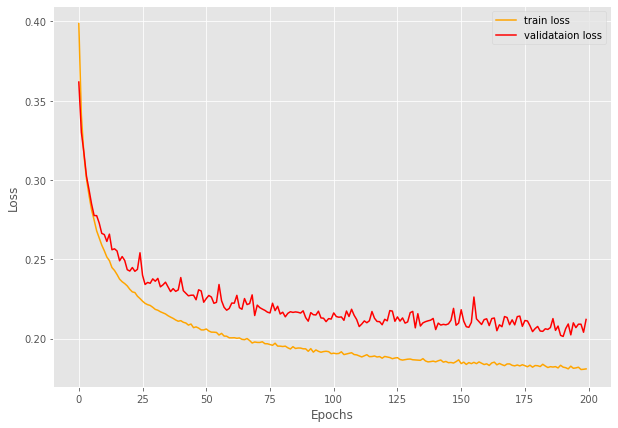

In [8]:
# save the trained model to disk
torch.save({
            'epoch': epochs,
            'model_state_dict': final_classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'outputs/last_model_' + DATA_FOLDER_NAME + '.pth')
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('outputs/loss_' + DATA_FOLDER_NAME + '.png')
plt.show()

In [9]:
checkpoint = torch.load('outputs/best_model_' + DATA_FOLDER_NAME + '.pth')
# load model weights state_dict
final_classifier.load_state_dict(checkpoint['model_state_dict'])

# test dataset
test_data = ClevrPOCDataSet(DATA_FOLDER, 'testing', total_labels_to_index, ENVIRONMENT_FOLDER)
# test data loader
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)


test_exact_acc, test_partial_acc = test(final_classifier, clip_model, test_loader, criterion, test_data, device, dropout, clip_preprocess, validation_threshold)
print('test_exact_acc', test_exact_acc)
print('test_partial_acc', test_partial_acc)


FileNotFoundError: [Errno 2] No such file or directory: 'outputs/best_model_output-12000.pth'

In [ ]:
print(3)